# Home Credit Default Risk - Machine Learning Project  

## Project Overview  
This project aims to predict **loan default risk** using historical credit data provided by the **Home Credit dataset**.  
By analyzing multiple financial datasets from past loan applications, we extract insights to improve risk assessment and minimize losses for lenders.  
While this model is trained specifically on Home Credit’s dataset, the process—data collection, preprocessing, feature engineering, and modeling—can be adapted to other financial institutions.  

## Live Application Deployment  
This project is also deployed as an **interactive Angular + Flask application**, allowing users to observe real-time model inference.  
🔗 **Try it here:** [Live Loan Default Predictor](https://ai.fullstackista.com/ai-loan-default-predictor/)  

### Key Steps in the Project  
1. **Understanding the Problem** – Define the objective: predict loan default risk using Home Credit data.  
2. **Data Processing & Feature Engineering** – Process multiple datasets, clean missing values, extract features, and aggregate information.  
3. **Exploratory Data Analysis (EDA)** – Identify trends, correlations, and risk factors in loan applications.  
4. **Merging Datasets** – Integrate primary (`application_train.csv`) and secondary datasets (e.g., `bureau.csv`, `credit_card_balance.csv`) for a unified view.  
5. **Model Training & Hyperparameter Tuning** – Train and optimize models (e.g., LightGBM) for predictive performance.  
6. **Model Evaluation** – Validate performance using metrics such as AUC-ROC.  
7. **Final Prediction** – Apply the trained model to `application_test.csv` and generate predictions.  

## About This Notebook  
This notebook processes the `previous_application.csv` dataset, which contains applicants' past loan applications.  
Processed features will be merged into the main dataset (`application_train.csv`) for model training.

## Project Notebooks  

### Main Dataset and Model Training  
- [1. Application Train (Main Dataset)](./01_application_train.ipynb)
- [2. Model Training and Final Pipeline](./02_model_training_pipeline.ipynb)  

### Secondary Datasets Processing  
- [3. Bureau Data](./03_bureau_data.ipynb)  
- [4. Bureau Balance Data](./04_bureau_balance.ipynb)  
- [5. Credit Card Balance](./05_credit_card_balance.ipynb)  
- [6. Previous Applications](./06_previous_applications.ipynb) _(Current Notebook)_
- [7. POS Cash Balance](./07_pos_cash_balance.ipynb)  
- [8. Installments Payments](./08_installments_payments.ipynb)  

### Final Prediction  
- [9. Model Predictions on Test Data](./09_model_predictions.ipynb)  
- [10. Application Test Data Processing](./10_application_test_processing.ipynb)

# Processing `previous_application.csv` (Past Loan Applications)

## 1. Load Data (`previous_application.csv`)
We start by loading the dataset and inspecting its structure to understand its key features and statistics.

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [2]:
# Load dataset
df_previous_application = pd.read_csv("/kaggle/input/home-credit-default-risk/previous_application.csv")

## 2. Initial Data Inspection (`previous_application.csv`)
Before processing, we inspect the dataset for potential issues such as **infinite values**, **missing values**, and other inconsistencies.

### 2.1 Checking for Infinite Values  
Infinite values (e.g., `inf`, `-inf`) can break numerical calculations and should be identified before proceeding.  
The code below scans for any **positive or negative infinite values** in the dataset.  

In [3]:
# Check for infinite values
print("Checking for infinite values in dataset...")
inf_count = (df_previous_application == np.inf).sum().sum()
neg_inf_count = (df_previous_application == -np.inf).sum().sum()

if inf_count > 0 or neg_inf_count > 0:
    print(f"⚠️ Found {inf_count} positive and {neg_inf_count} negative infinite values!")
else:
    print("✅ No infinite values detected.")

Checking for infinite values in dataset...
✅ No infinite values detected.


### 2.2 Checking for Missing Values (NaNs)  
Missing values (**NaNs**) can affect model performance and should be handled properly.  
Here, we count the number of missing values in each column and print the results.

In [4]:
# Check for missing values
missing_values = df_previous_application.isnull().sum()
missing_values = missing_values[missing_values > 0]  

if not missing_values.empty:
    print("⚠️ Missing values detected in columns:")
    print(missing_values)
else:
    print("✅ No missing values detected.")

⚠️ Missing values detected in columns:
AMT_ANNUITY                   372235
AMT_CREDIT                         1
AMT_DOWN_PAYMENT              895844
AMT_GOODS_PRICE               385515
RATE_DOWN_PAYMENT             895844
RATE_INTEREST_PRIMARY        1664263
RATE_INTEREST_PRIVILEGED     1664263
NAME_TYPE_SUITE               820405
CNT_PAYMENT                   372230
PRODUCT_COMBINATION              346
DAYS_FIRST_DRAWING            673065
DAYS_FIRST_DUE                673065
DAYS_LAST_DUE_1ST_VERSION     673065
DAYS_LAST_DUE                 673065
DAYS_TERMINATION              673065
NFLAG_INSURED_ON_APPROVAL     673065
dtype: int64


### 2.3 Print Dataset Columns  
To get an overview of the dataset structure, we print the column names.  
This helps us understand the available features and identify any inconsistencies.

In [5]:
# Print column names
print(df_previous_application.columns)

Index(['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY',
       'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY',
       'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY',
       'RATE_INTEREST_PRIVILEGED', 'NAME_CASH_LOAN_PURPOSE',
       'NAME_CONTRACT_STATUS', 'DAYS_DECISION', 'NAME_PAYMENT_TYPE',
       'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE',
       'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE',
       'CHANNEL_TYPE', 'SELLERPLACE_AREA', 'NAME_SELLER_INDUSTRY',
       'CNT_PAYMENT', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
       'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
       'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL'],
      dtype='object')


### 2.4 Detecting Extreme Values (Outliers)  

Extreme values (**outliers**) can skew model performance and lead to **unstable predictions**.  
We detect outliers using **percentile thresholds**:  

- **Above the 99th percentile** → Very large values.  
- **Below the 1st percentile** → Very small values.  

In [6]:
# Check for extreme values using percentile-based thresholds 
print("Checking for extreme values in 'previous application' dataset using percentile thresholds...")

# Exclude ID columns from percentile-based detection
extreme_exclude_cols = ['SK_ID_CURR', 'SK_ID_PREV']
extreme_numeric_columns = df_previous_application.select_dtypes(include=["number"]).drop(columns=extreme_exclude_cols, errors='ignore')

# Compute percentile-based thresholds
extreme_upper_threshold = extreme_numeric_columns.quantile(0.99)
extreme_lower_threshold = extreme_numeric_columns.quantile(0.01)

# Identify extreme values
extreme_large_columns = extreme_numeric_columns.max() > extreme_upper_threshold
extreme_small_columns = extreme_numeric_columns.min() < extreme_lower_threshold

# Print results
if extreme_large_columns.any():
    print(f"⚠️ Columns with very large values (above 99th percentile):\n{extreme_numeric_columns.loc[:, extreme_large_columns].max()}")
if extreme_small_columns.any():
    print(f"⚠️ Columns with very small values (below 1st percentile):\n{extreme_numeric_columns.loc[:, extreme_small_columns].min()}")
if not extreme_large_columns.any() and not extreme_small_columns.any():
    print("✅ No extreme values detected in 'previous application' dataset.")

Checking for extreme values in 'previous application' dataset using percentile thresholds...
⚠️ Columns with very large values (above 99th percentile):
AMT_ANNUITY                  418058.145
AMT_APPLICATION             6905160.000
AMT_CREDIT                  6905160.000
AMT_DOWN_PAYMENT            3060045.000
AMT_GOODS_PRICE             6905160.000
HOUR_APPR_PROCESS_START          23.000
RATE_DOWN_PAYMENT                 1.000
RATE_INTEREST_PRIMARY             1.000
RATE_INTEREST_PRIVILEGED          1.000
DAYS_DECISION                    -1.000
SELLERPLACE_AREA            4000000.000
CNT_PAYMENT                      84.000
dtype: float64
⚠️ Columns with very small values (below 1st percentile):
AMT_ANNUITY                     0.000000
AMT_DOWN_PAYMENT               -0.900000
AMT_GOODS_PRICE                 0.000000
HOUR_APPR_PROCESS_START         0.000000
NFLAG_LAST_APPL_IN_DAY          0.000000
RATE_DOWN_PAYMENT              -0.000015
RATE_INTEREST_PRIMARY           0.034781
RATE_INT

### 2.5 Checking Dataset Shape  

The dataset's shape provides a quick view of its size, showing the number of **rows** (loan records) and **columns** (features).  

In [7]:
# Check the shape of the dataset
print("DataFrame Shape:", df_previous_application.shape)

DataFrame Shape: (1670214, 37)


### 2.6 Viewing Sample Data (`head()`)  

To understand the dataset, we display the **first few rows**.  
This helps verify that data is loaded correctly and gives an initial sense of feature distributions.  

In [8]:
# Display first few rows of the dataset
print("First few rows of previous application DataFrame:")
display(df_previous_application.head())

First few rows of previous application DataFrame:


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


### 2.7 Dataset Summary (`info()`)  

The `info()` function provides:  
- **Column names and types** (e.g., integer, float, categorical).  
- **Non-null counts** (to check for missing data).  
- **Memory usage**, which is useful for optimizing performance.  

In [9]:
# Get a concise summary of the DataFrame
print("DataFrame Info:")
df_previous_application.info()

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT         

### 2.8 Descriptive Statistics  

We generate summary statistics for:  
- **Numeric columns** (`describe()`) → Mean, standard deviation, min/max, and quartiles.  
- **Categorical columns** (`describe(include='object')`) → Count of unique values, most frequent categories.  
This helps in **understanding distributions** and identifying possible anomalies.  

In [10]:
# Get summary statistics of columns
print("\nDescriptive Statistics:")
display(df_previous_application.describe())  # For numeric columns
display(df_previous_application.describe(include="object"))


Descriptive Statistics:


,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,...,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,1.670214e+06,1.670214e+06,1.297979e+06,1.670214e+06,1.670213e+06,7.743700e+05,1.284699e+06,1.670214e+06,1.670214e+06,774370.000000,...,5951.000000,1.670214e+06,1.670214e+06,1.297984e+06,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000
mean,1.923089e+06,2.783572e+05,1.595512e+04,1.752339e+05,1.961140e+05,6.697402e+03,2.278473e+05,1.248418e+01,9.964675e-01,0.079637,...,0.773503,-8.806797e+02,3.139511e+02,1.605408e+01,342209.855039,13826.269337,33767.774054,76582.403064,81992.343838,0.332570
std,5.325980e+05,1.028148e+05,1.478214e+04,2.927798e+05,3.185746e+05,2.092150e+04,3.153966e+05,3.334028e+00,5.932963e-02,0.107823,...,0.100879,7.790997e+02,7.127443e+03,1.456729e+01,88916.115834,72444.869708,106857.034789,149647.415123,153303.516729,0.471134
min,1.000001e+06,1.000010e+05,0.000000e+00,0.000000e+00,0.000000e+00,-9.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,-0.000015,...,0.373150,-2.922000e+03,-1.000000e+00,0.000000e+00,-2922.000000,-2892.000000,-2801.000000,-2889.000000,-2874.000000,0.000000
25%,1.461857e+06,1.893290e+05,6.321780e+03,1.872000e+04,2.416050e+04,0.000000e+00,5.084100e+04,1.000000e+01,1.000000e+00,0.000000,...,0.715645,-1.300000e+03,-1.000000e+00,6.000000e+00,365243.000000,-1628.000000,-1242.000000,-1314.000000,-1270.000000,0.000000
50%,1.923110e+06,2.787145e+05,1.125000e+04,7.104600e+04,8.054100e+04,1.638000e+03,1.123200e+05,1.200000e+01,1.000000e+00,0.051605,...,0.835095,-5.810000e+02,3.000000e+00,1.200000e+01,365243.000000,-831.000000,-361.000000,-537.000000,-499.000000,0.000000
75%,2.384280e+06,3.675140e+05,2.065842e+04,1.803600e+05,2.164185e+05,7.740000e+03,2.340000e+05,1.500000e+01,1.000000e+00,0.108909,...,0.852537,-2.800000e+02,8.200000e+01,2.400000e+01,365243.000000,-411.000000,129.000000,-74.000000,-44.000000,1.000000
max,2.845382e+06,4.562550e+05,4.180581e+05,6.905160e+06,6.905160e+06,3.060045e+06,6.905160e+06,2.300000e+01,1.000000e+00,1.000000,...,1.000000,-1.000000e+00,4.000000e+06,8.400000e+01,365243.000000,365243.000000,365243.000000,365243.000000,365243.000000,1.000000


,NAME_CONTRACT_TYPE,WEEKDAY_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,NAME_SELLER_INDUSTRY,NAME_YIELD_GROUP,PRODUCT_COMBINATION
count,1670214,1670214,1670214,1670214,1670214,1670214,1670214,849809,1670214,1670214,1670214,1670214,1670214,1670214,1670214,1669868
unique,4,7,2,25,4,4,9,7,4,28,5,3,8,11,5,17
top,Cash loans,TUESDAY,Y,XAP,Approved,Cash through the bank,XAP,Unaccompanied,Repeater,XNA,POS,XNA,Credit and cash offices,XNA,XNA,Cash
freq,747553,255118,1661739,922661,1036781,1033552,1353093,508970,1231261,950809,691011,1063666,719968,855720,517215,285990


## 3. Initial Data Cleaning (`previous_application.csv`)
After identifying potential issues, we clean the dataset by handling **infinite values, categorical features, and potential misclassified columns**.

### 3.1 Replacing Infinite Values  
Since infinite values (`inf`, `-inf`) can interfere with model training, we replace them with `NaN` to handle them properly later.  

In [11]:
# Replace infinite values with NaN before handling missing values
df_previous_application.replace([np.inf, -np.inf], np.nan, inplace=True)
print("✅ Infinite values replaced with NaN.")

✅ Infinite values replaced with NaN.


### 3.2 Converting Categorical Features  
Some columns are stored as `object` or numeric types but should be categorical.  
We identify and convert relevant columns to the **category dtype** for efficiency and proper encoding.  

In [12]:
# Step 1: Detect categorical columns stored as 'object' (text-based categories)
categorical_columns = df_previous_application.select_dtypes(include=['object']).columns.tolist()

# Step 2: Detect numeric columns with low unique values that should be categorical
low_unique_cols = df_previous_application.nunique()
numeric_categoricals = low_unique_cols[(low_unique_cols < 20) & (df_previous_application.dtypes != 'object')].index.tolist()

# Step 3: Apply automated selection (only keep categorical columns with < 20 unique values)
final_categorical_columns = [col for col in categorical_columns if df_previous_application[col].nunique() < 20]
final_categorical_columns += numeric_categoricals  # Add numeric categorical variables

# Convert automatically detected categorical columns
df_previous_application[final_categorical_columns] = df_previous_application[final_categorical_columns].astype("category")

print(f"✅ Automatically converted categorical columns: {final_categorical_columns}")

✅ Automatically converted categorical columns: ['NAME_CONTRACT_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE', 'NAME_SELLER_INDUSTRY', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION', 'NFLAG_LAST_APPL_IN_DAY', 'NFLAG_INSURED_ON_APPROVAL']


### 3.3 Checking Unique Values in Categorical Columns  
To ensure correct data types, we print the number of unique values in categorical columns.  
This helps verify if any unexpected categories exist.  

In [13]:
print("Unique values in categorical columns:")
for col in final_categorical_columns:
    print(f"{col}: {df_previous_application[col].nunique()} unique values")

Unique values in categorical columns:
NAME_CONTRACT_TYPE: 4 unique values
WEEKDAY_APPR_PROCESS_START: 7 unique values
FLAG_LAST_APPL_PER_CONTRACT: 2 unique values
NAME_CONTRACT_STATUS: 4 unique values
NAME_PAYMENT_TYPE: 4 unique values
CODE_REJECT_REASON: 9 unique values
NAME_TYPE_SUITE: 7 unique values
NAME_CLIENT_TYPE: 4 unique values
NAME_PORTFOLIO: 5 unique values
NAME_PRODUCT_TYPE: 3 unique values
CHANNEL_TYPE: 8 unique values
NAME_SELLER_INDUSTRY: 11 unique values
NAME_YIELD_GROUP: 5 unique values
PRODUCT_COMBINATION: 17 unique values
NFLAG_LAST_APPL_IN_DAY: 2 unique values
NFLAG_INSURED_ON_APPROVAL: 2 unique values


### 3.4 Optimizing Categorical Columns  
High-cardinality categorical columns are converted to the `category` dtype to improve **memory efficiency**.

In [14]:
df_previous_application['NAME_GOODS_CATEGORY'] = df_previous_application['NAME_GOODS_CATEGORY'].astype('category')
df_previous_application['NAME_CASH_LOAN_PURPOSE'] = df_previous_application['NAME_CASH_LOAN_PURPOSE'].astype('category')

print("✅ Converted high-cardinality categorical columns to 'category' dtype for memory efficiency.")

✅ Converted high-cardinality categorical columns to 'category' dtype for memory efficiency.


### 3.5 Displaying Updated Data Types  

After data cleaning, we check if all columns have the correct data types.  
This ensures that categorical, numeric, and ID columns are properly assigned before further processing.  

In [15]:
# Display all columns and their data types
pd.set_option('display.max_rows', None) 
print("✅ Updated Data Types:")
print(df_previous_application.dtypes)
pd.reset_option('display.max_rows')

✅ Updated Data Types:
SK_ID_PREV                        int64
SK_ID_CURR                        int64
NAME_CONTRACT_TYPE             category
AMT_ANNUITY                     float64
AMT_APPLICATION                 float64
AMT_CREDIT                      float64
AMT_DOWN_PAYMENT                float64
AMT_GOODS_PRICE                 float64
WEEKDAY_APPR_PROCESS_START     category
HOUR_APPR_PROCESS_START           int64
FLAG_LAST_APPL_PER_CONTRACT    category
NFLAG_LAST_APPL_IN_DAY         category
RATE_DOWN_PAYMENT               float64
RATE_INTEREST_PRIMARY           float64
RATE_INTEREST_PRIVILEGED        float64
NAME_CASH_LOAN_PURPOSE         category
NAME_CONTRACT_STATUS           category
DAYS_DECISION                     int64
NAME_PAYMENT_TYPE              category
CODE_REJECT_REASON             category
NAME_TYPE_SUITE                category
NAME_CLIENT_TYPE               category
NAME_GOODS_CATEGORY            category
NAME_PORTFOLIO                 category
NAME_PRODUCT_TYPE 

### 3.6 Handling Missing Values  
Missing values can impact model performance, so we analyze and handle them based on their percentage.  

#### 3.6.1 Checking for Missing Values  
We first identify missing values in each column to understand their distribution.  

In [16]:
# Check for missing values
pd.set_option('display.max_rows', None) 
print("Missing values in each column:")
print(df_previous_application.isnull().sum())
pd.reset_option('display.max_rows')

Missing values in each column:
SK_ID_PREV                           0
SK_ID_CURR                           0
NAME_CONTRACT_TYPE                   0
AMT_ANNUITY                     372235
AMT_APPLICATION                      0
AMT_CREDIT                           1
AMT_DOWN_PAYMENT                895844
AMT_GOODS_PRICE                 385515
WEEKDAY_APPR_PROCESS_START           0
HOUR_APPR_PROCESS_START              0
FLAG_LAST_APPL_PER_CONTRACT          0
NFLAG_LAST_APPL_IN_DAY               0
RATE_DOWN_PAYMENT               895844
RATE_INTEREST_PRIMARY          1664263
RATE_INTEREST_PRIVILEGED       1664263
NAME_CASH_LOAN_PURPOSE               0
NAME_CONTRACT_STATUS                 0
DAYS_DECISION                        0
NAME_PAYMENT_TYPE                    0
CODE_REJECT_REASON                   0
NAME_TYPE_SUITE                 820405
NAME_CLIENT_TYPE                     0
NAME_GOODS_CATEGORY                  0
NAME_PORTFOLIO                       0
NAME_PRODUCT_TYPE                

#### 3.6.2 Identifying "XNA" as Missing Values  
Some categorical columns contain `"XNA"`, which may represent missing or unknown values.  
To handle them correctly, we first count occurrences of `"XNA"` in each categorical column.  
This helps determine the extent of missing values before replacement.

In [17]:
# Count occurrences of "XNA" in categorical columns (including 'category' dtype)
xna_counts = df_previous_application.select_dtypes(include=["category"]).apply(lambda col: (col == "XNA").sum())

# Display only columns where "XNA" appears
xna_counts = xna_counts[xna_counts > 0]

print("Number of 'XNA' values per column:")
print(xna_counts)

Number of 'XNA' values per column:
NAME_CONTRACT_TYPE            346
NAME_CASH_LOAN_PURPOSE     677918
NAME_PAYMENT_TYPE          627384
CODE_REJECT_REASON           5244
NAME_CLIENT_TYPE             1941
NAME_GOODS_CATEGORY        950809
NAME_PORTFOLIO             372230
NAME_PRODUCT_TYPE         1063666
NAME_SELLER_INDUSTRY       855720
NAME_YIELD_GROUP           517215
dtype: int64


#### 3.6.3 Replacing "XNA" with NaN  
Since `"XNA"` likely represents missing values, we replace it with `NaN` for proper handling.  
This ensures consistency in categorical columns and improves model performance.  
After replacement, we convert these columns back to the `"category"` dtype for memory efficiency.

In [18]:
# Convert "XNA" to NaN in categorical columns (final clean version)
xna_as_nan_columns = [
    "NAME_CONTRACT_TYPE",  
    "NAME_CASH_LOAN_PURPOSE",
    "NAME_PAYMENT_TYPE",
    "CODE_REJECT_REASON",
    "NAME_CLIENT_TYPE",
    "NAME_GOODS_CATEGORY",
    "NAME_PORTFOLIO",
    "NAME_PRODUCT_TYPE",
    "NAME_SELLER_INDUSTRY",
    "NAME_YIELD_GROUP"
]


# Ensure proper conversion
for col in xna_as_nan_columns:
    df_previous_application[col] = df_previous_application[col].astype(str)  # Convert to string
    df_previous_application[col] = df_previous_application[col].replace(["XNA", "nan"], np.nan)  # Convert to NaN
    df_previous_application[col] = df_previous_application[col].astype("category")  # Convert back to category

print("✅ Successfully replaced 'XNA' with NaN in categorical columns.")

✅ Successfully replaced 'XNA' with NaN in categorical columns.


#### 3.6.4 Calculating Missing Value Percentages  
To categorize missing values, we define thresholds:  
- **Low**: Less than 1% missing (likely safe to fill with median/mean).  
- **Moderate**: 1%–20% missing (requires careful handling).  
- **High**: More than 50% missing (usually dropped unless critical).  

In [19]:
# Define missing value thresholds 
low_threshold = 1  # Less than 1% missing
moderate_threshold = 20  # Between 1% and 20% missing
high_threshold = 50  # More than 50% missing 

# Calculate missing value percentage
missing_percent = (df_previous_application.isnull().sum() / len(df_previous_application)) * 100  

# Display missing percentages
print("Missing Value Percentages:")
display(missing_percent[missing_percent > 0].sort_values(ascending=False).apply(lambda x: f"{x:.2f}%")) 

Missing Value Percentages:


RATE_INTEREST_PRIMARY        99.64%
RATE_INTEREST_PRIVILEGED     99.64%
NAME_PRODUCT_TYPE            63.68%
NAME_GOODS_CATEGORY          56.93%
AMT_DOWN_PAYMENT             53.64%
RATE_DOWN_PAYMENT            53.64%
NAME_SELLER_INDUSTRY         51.23%
NAME_TYPE_SUITE              49.12%
NAME_CASH_LOAN_PURPOSE       40.59%
DAYS_TERMINATION             40.30%
DAYS_LAST_DUE                40.30%
DAYS_LAST_DUE_1ST_VERSION    40.30%
DAYS_FIRST_DUE               40.30%
DAYS_FIRST_DRAWING           40.30%
NFLAG_INSURED_ON_APPROVAL    40.30%
NAME_PAYMENT_TYPE            37.56%
NAME_YIELD_GROUP             30.97%
AMT_GOODS_PRICE              23.08%
AMT_ANNUITY                  22.29%
NAME_PORTFOLIO               22.29%
CNT_PAYMENT                  22.29%
CODE_REJECT_REASON            0.31%
NAME_CLIENT_TYPE              0.12%
PRODUCT_COMBINATION           0.02%
NAME_CONTRACT_TYPE            0.02%
AMT_CREDIT                    0.00%
dtype: object

#### 3.6.5 Dropping Columns with Excessive Missing Data  
Columns with **more than 50% missing values** are removed to prevent data leakage and reduce noise.  

In [20]:
# Identify columns to drop (more than 50% missing values)
columns_to_drop = missing_percent[missing_percent > high_threshold].index

# Drop columns
df_previous_application.drop(columns=columns_to_drop, inplace=True)

print(f"✅ Dropped {len(columns_to_drop)} columns with more than 50% missing values: {list(columns_to_drop)}")

✅ Dropped 7 columns with more than 50% missing values: ['AMT_DOWN_PAYMENT', 'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED', 'NAME_GOODS_CATEGORY', 'NAME_PRODUCT_TYPE', 'NAME_SELLER_INDUSTRY']


### 3.7 Filling Missing Values  

To ensure data completeness, we fill missing values in both **numeric** and **categorical** columns using appropriate strategies.  
- **Numeric values** → Filled with **median** (robust to outliers).  
- **Categorical values** → Filled with **mode** (most frequent category).  

In [21]:
# Fill numeric columns with median
numeric_cols_to_fill = df_previous_application.select_dtypes(include=['int64', 'float64']).columns
df_previous_application[numeric_cols_to_fill] = df_previous_application[numeric_cols_to_fill].fillna(df_previous_application[numeric_cols_to_fill].median())

print("✅ Filled numeric missing values with median.")

✅ Filled numeric missing values with median.


In [22]:
# Fill categorical columns with mode
categorical_cols_to_fill = df_previous_application.select_dtypes(include=['category']).columns
for col in categorical_cols_to_fill:
    df_previous_application[col] = df_previous_application[col].fillna(df_previous_application[col].mode()[0]) 

print("✅ Filled categorical missing values with mode.")

✅ Filled categorical missing values with mode.


### 3.8 Final Missing Values Check  
After filling missing values, we perform a final check to confirm that **no NaNs remain** in the dataset.  

In [23]:
print("Final Missing Values Check:")
print(df_previous_application.isnull().sum().sum())

Final Missing Values Check:
0


### 3.9 Checking for Duplicates  
Duplicate rows can cause data leakage and distort model training.  
We check for duplicates and ensure that no redundant rows exist.  

In [24]:
# Check for duplicates
print("Number of duplicate rows:", df_previous_application.duplicated().sum())

Number of duplicate rows: 0


### 3.10 Saving the Cleaned Dataset  

Before saving, we **verify all column data types** to ensure correctness after processing.  

We save the cleaned dataset for the following purpose:  

**Feature Ranges for Dummy Data** → This dataset is later used in the **Angular + Flask app** to generate test data for predictions.  

In [25]:
# Display all columns and their data types
pd.set_option('display.max_rows', None) 
print("✅ Updated Data Types for df_previous_application:")
print(df_previous_application.dtypes)
pd.reset_option('display.max_rows')

✅ Updated Data Types for df_previous_application:
SK_ID_PREV                        int64
SK_ID_CURR                        int64
NAME_CONTRACT_TYPE             category
AMT_ANNUITY                     float64
AMT_APPLICATION                 float64
AMT_CREDIT                      float64
AMT_GOODS_PRICE                 float64
WEEKDAY_APPR_PROCESS_START     category
HOUR_APPR_PROCESS_START           int64
FLAG_LAST_APPL_PER_CONTRACT    category
NFLAG_LAST_APPL_IN_DAY         category
NAME_CASH_LOAN_PURPOSE         category
NAME_CONTRACT_STATUS           category
DAYS_DECISION                     int64
NAME_PAYMENT_TYPE              category
CODE_REJECT_REASON             category
NAME_TYPE_SUITE                category
NAME_CLIENT_TYPE               category
NAME_PORTFOLIO                 category
CHANNEL_TYPE                   category
SELLERPLACE_AREA                  int64
CNT_PAYMENT                     float64
NAME_YIELD_GROUP               category
PRODUCT_COMBINATION           

In [26]:
df_previous_application.to_csv("cleaned_previous_application.csv")
df_previous_application.to_pickle("cleaned_previous_application.pkl")

print("✅ Cleaned Previous Application dataset saved successfully!")

✅ Cleaned Previous Application dataset saved successfully!


## 4. Exploratory Data Analysis (`previous_application.csv`)

EDA helps us **understand data distributions, correlations, and patterns** that might impact feature engineering.  

### 4.1 Summary Statistics  

We first generate summary statistics for both **numeric** and **categorical features** to check distributions, outliers, and data consistency.  

In [27]:
### Summary Statistics
pd.set_option('display.max_columns', None)

# Numeric summary
print("Summary Statistics (Numeric Features):")
display(df_previous_application.describe().T)

# Categorical summary
print("Summary Statistics (Categorical Features):")
display(df_previous_application.describe(include=["category"]).T)

pd.reset_option('display.max_columns')

Summary Statistics (Numeric Features):


,count,mean,std,min,25%,50%,75%,max
SK_ID_PREV,1670214.0,1.923089e+06,532597.958696,1000001.0,1.461857e+06,1923110.5,2.384280e+06,2845382.000
SK_ID_CURR,1670214.0,2.783572e+05,102814.823849,100001.0,1.893290e+05,278714.5,3.675140e+05,456255.000
AMT_ANNUITY,1670214.0,1.490651e+04,13177.514097,0.0,7.547096e+03,11250.0,1.682403e+04,418058.145
AMT_APPLICATION,1670214.0,1.752339e+05,292779.762387,0.0,1.872000e+04,71046.0,1.803600e+05,6905160.000
AMT_CREDIT,1670214.0,1.961140e+05,318574.533729,0.0,2.416050e+04,80541.0,2.164185e+05,6905160.000
AMT_GOODS_PRICE,1670214.0,2.011815e+05,280862.857160,0.0,6.750000e+04,112320.0,1.804050e+05,6905160.000
HOUR_APPR_PROCESS_START,1670214.0,1.248418e+01,3.334028,0.0,1.000000e+01,12.0,1.500000e+01,23.000
DAYS_DECISION,1670214.0,-8.806797e+02,779.099667,-2922.0,-1.300000e+03,-581.0,-2.800000e+02,-1.000
SELLERPLACE_AREA,1670214.0,3.139511e+02,7127.443459,-1.0,-1.000000e+00,3.0,8.200000e+01,4000000.000
CNT_PAYMENT,1670214.0,1.515057e+01,12.952198,0.0,1.000000e+01,12.0,1.600000e+01,84.000


Summary Statistics (Categorical Features):


,count,unique,top,freq
NAME_CONTRACT_TYPE,1670214,3,Cash loans,747899
WEEKDAY_APPR_PROCESS_START,1670214,7,TUESDAY,255118
FLAG_LAST_APPL_PER_CONTRACT,1670214,2,Y,1661739
NFLAG_LAST_APPL_IN_DAY,1670214,2,1,1664314
NAME_CASH_LOAN_PURPOSE,1670214,24,XAP,1600579
NAME_CONTRACT_STATUS,1670214,4,Approved,1036781
NAME_PAYMENT_TYPE,1670214,3,Cash through the bank,1660936
CODE_REJECT_REASON,1670214,8,XAP,1358337
NAME_TYPE_SUITE,1670214,7,Unaccompanied,1329375
NAME_CLIENT_TYPE,1670214,3,Repeater,1233202


### 4.2 Correlation Analysis  

We calculate feature correlations to detect **strongly related variables**.  
This helps identify **redundant features** and potential **new interactions** for modeling.  

In [28]:
# Select only numeric columns from df_previous_application
numeric_data = df_previous_application.select_dtypes(include=[np.number])

# Calculate the correlation matrix
corr_matrix = numeric_data.corr()

# Display top 10 most correlated feature pairs (excluding self-correlations)
print("Top 10 Most Correlated Features in `df_previous_application`:")
corr_pairs = corr_matrix.unstack().sort_values(ascending=False)
corr_pairs = corr_pairs[corr_pairs < 1]  # Remove self-correlations
print(corr_pairs.head(10))

Top 10 Most Correlated Features in `df_previous_application`:
AMT_GOODS_PRICE   AMT_APPLICATION     0.987143
AMT_APPLICATION   AMT_GOODS_PRICE     0.987143
                  AMT_CREDIT          0.975824
AMT_CREDIT        AMT_APPLICATION     0.975824
AMT_GOODS_PRICE   AMT_CREDIT          0.971117
AMT_CREDIT        AMT_GOODS_PRICE     0.971117
DAYS_TERMINATION  DAYS_LAST_DUE       0.935149
DAYS_LAST_DUE     DAYS_TERMINATION    0.935149
AMT_ANNUITY       AMT_GOODS_PRICE     0.816293
AMT_GOODS_PRICE   AMT_ANNUITY         0.816293
dtype: float64


### Key Takeaways:
- **Strong correlation (>0.97)** between `AMT_GOODS_PRICE`, `AMT_APPLICATION`, and `AMT_CREDIT` suggests these features might be redundant.
- `DAYS_TERMINATION` and `DAYS_LAST_DUE` have a **high correlation (~0.93)**, meaning one may be dropped or transformed.
- `AMT_ANNUITY` and `AMT_GOODS_PRICE` show a **moderate correlation (~0.82)**, indicating a relationship but likely retaining unique predictive value.

### 4.3 Correlation Heatmap  

We visualize the correlation matrix using a **heatmap** to detect strongly related features.  
This helps identify **redundant features** and possible **new interactions** for modeling.  

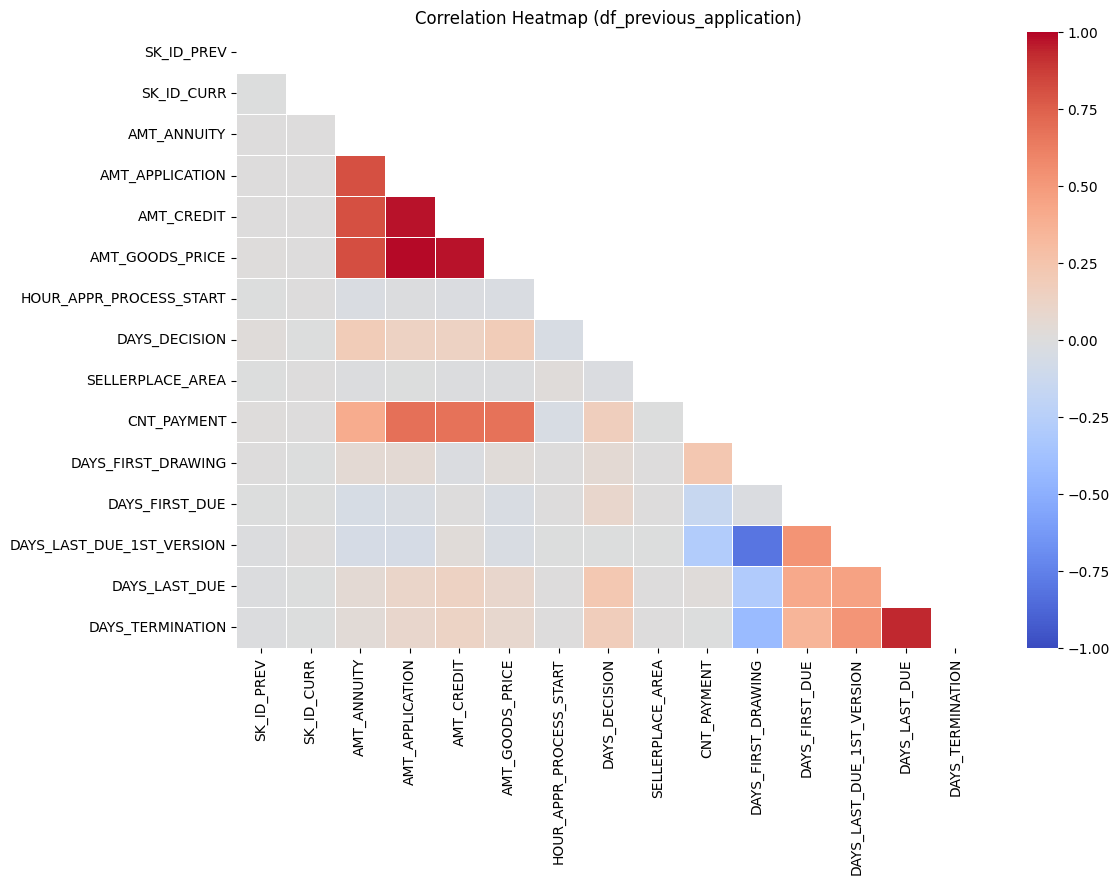

In [29]:
# Visualize the correlation matrix using a heatmap
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set figure size
plt.figure(figsize=(12, 8))

# Create heatmap
sns.heatmap(
    corr_matrix, 
    mask=mask, 
    annot=False,  # Remove annotation for readability
    cmap="coolwarm", 
    linewidths=0.5, 
    vmin=-1, vmax=1  # Standardize color scale
)

# Title
plt.title("Correlation Heatmap (df_previous_application)")
plt.show()

### Key Takeaways:
- **Clusters of strong correlations** appear among loan amount features (`AMT_APPLICATION`, `AMT_CREDIT`, `AMT_GOODS_PRICE`), indicating potential redundancy.
- **Time-related variables** like `DAYS_TERMINATION`, `DAYS_LAST_DUE`, and `DAYS_FIRST_DUE` show high correlations, suggesting they capture similar past loan repayment timing.
- The **heatmap highlights weakly correlated features**, which may contain independent information valuable for predictive modeling.

### 4.4 Visualizing Outliers  

We plot boxplots of key numerical features to detect **potential extreme values**.  
Since LightGBM handles outliers efficiently, **no transformations** are applied.  

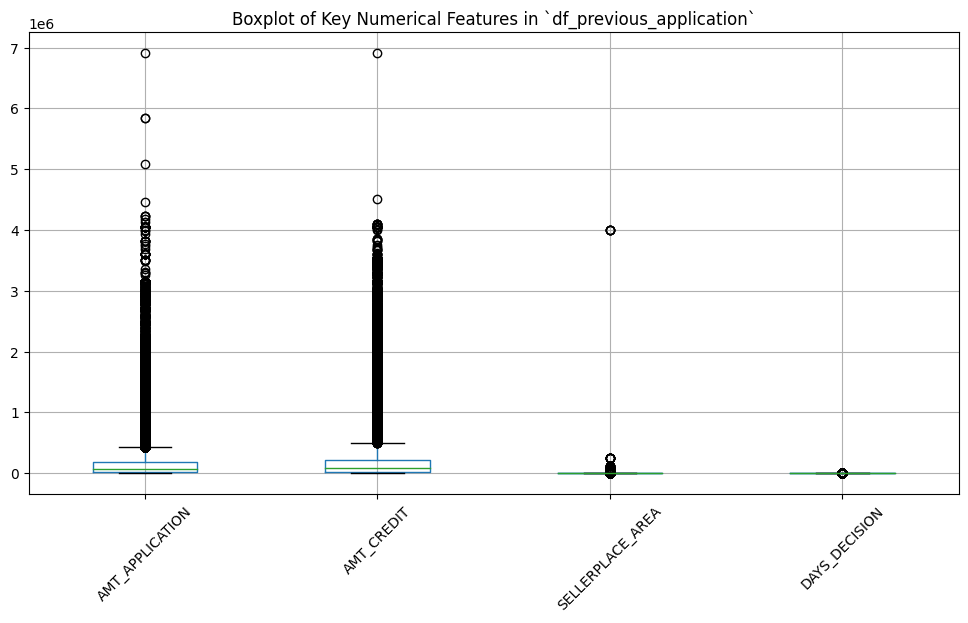

In [30]:
# Selected key numeric features for outlier detection
outlier_columns = [
    "AMT_APPLICATION", "AMT_CREDIT", "SELLERPLACE_AREA", "DAYS_DECISION"
]

# Create boxplot
plt.figure(figsize=(12, 6))
df_previous_application[outlier_columns].boxplot()

# Title
plt.title("Boxplot of Key Numerical Features in `df_previous_application`")
plt.xticks(rotation=45)  
plt.show()

### Key Takeaways:
- **Extreme values** are observed in `AMT_APPLICATION` and `AMT_CREDIT`, suggesting a wide range of loan amounts, likely due to high-value applications.
- `SELLERPLACE_AREA` and `DAYS_DECISION` have **fewer extreme values**, indicating less variability compared to loan amount features.
- While some models handle outliers efficiently, understanding their distribution helps in deciding whether transformations or outlier handling techniques are needed.

### 4.5 Pair Plot Analysis
Skipping the pair plot because most numerical features are either highly correlated (`AMT_APPLICATION` vs. `AMT_CREDIT`) or time-based (`DAYS_DECISION`), making scatter plots redundant.

### 4.6 Group-wise Analysis

Group-wise analysis helps us understand how numerical features vary across different categorical groups.
- We examine how a numerical feature is distributed across different categorical values.
- Boxplots are used to visualize variations and identify potential trends.
- This helps detect disparities and patterns that could be relevant for further modeling.

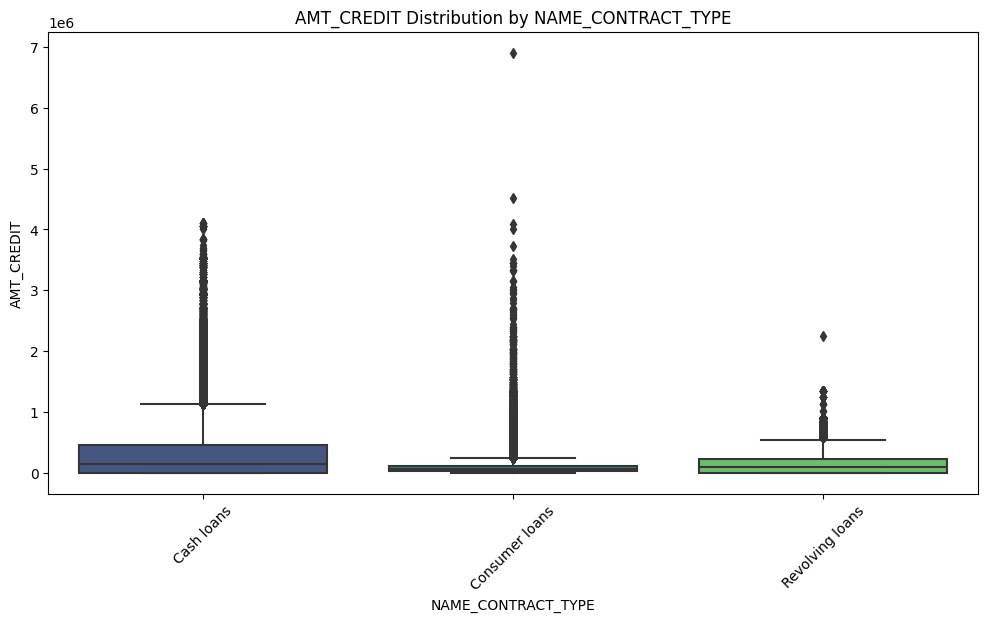

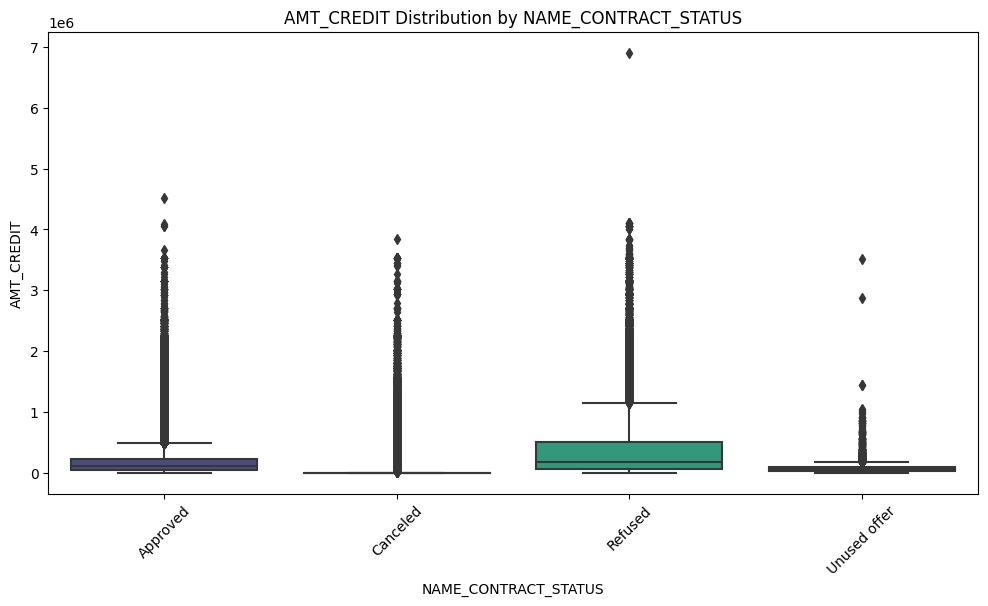

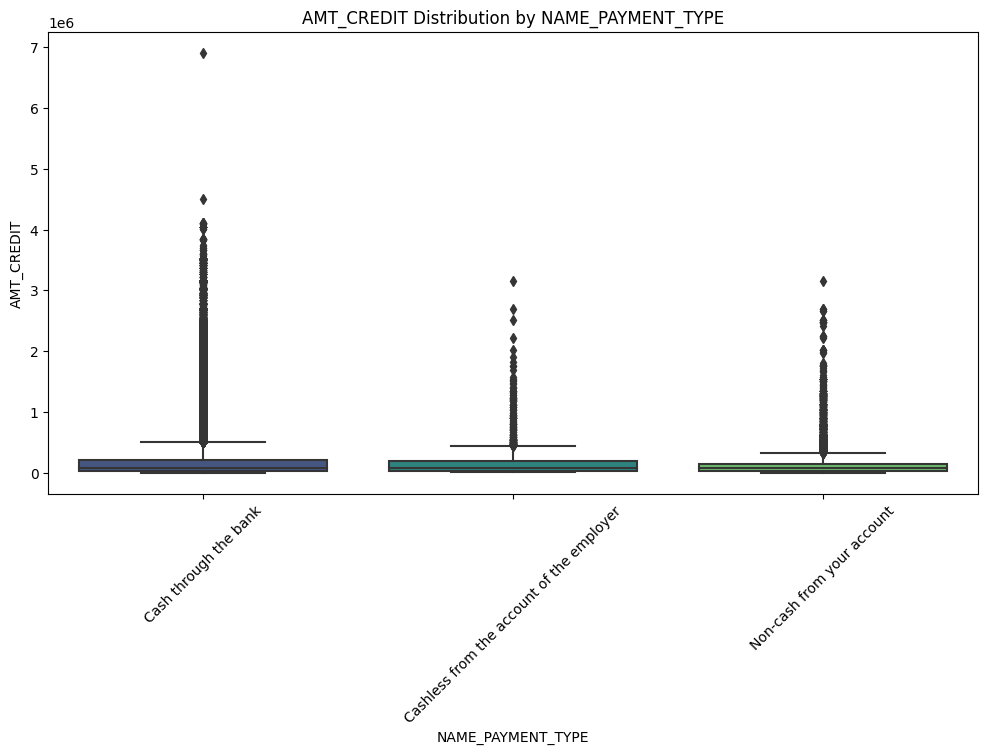

In [31]:
# Selected categorical columns for group-wise analysis
categorical_cols_boxplot = ["NAME_CONTRACT_TYPE", "NAME_CONTRACT_STATUS", "NAME_PAYMENT_TYPE"]

# Selected numerical column (approved loan amount)
numeric_col_boxplot = "AMT_CREDIT"

for column in categorical_cols_boxplot:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=column, y=numeric_col_boxplot, data=df_previous_application, palette="viridis", dodge=False)
    plt.title(f"{numeric_col_boxplot} Distribution by {column}")
    plt.xticks(rotation=45)
    plt.show()

### Key Takeaways:
- **Loan amounts vary significantly** across different contract types, with **cash loans and consumer loans** showing the highest credit amounts.
- **Refused applications** tend to have higher credit amounts compared to approved ones, indicating that higher-risk applicants request larger loans.
- **Payment type has minimal impact on loan amounts**, suggesting that credit amount is largely independent of how the loan is disbursed.

### 4.7 Time-wise Analysis
We analyze how key features evolve over time to detect **trends, seasonality, or anomalies**.  
This helps in identifying patterns that might improve feature engineering. 

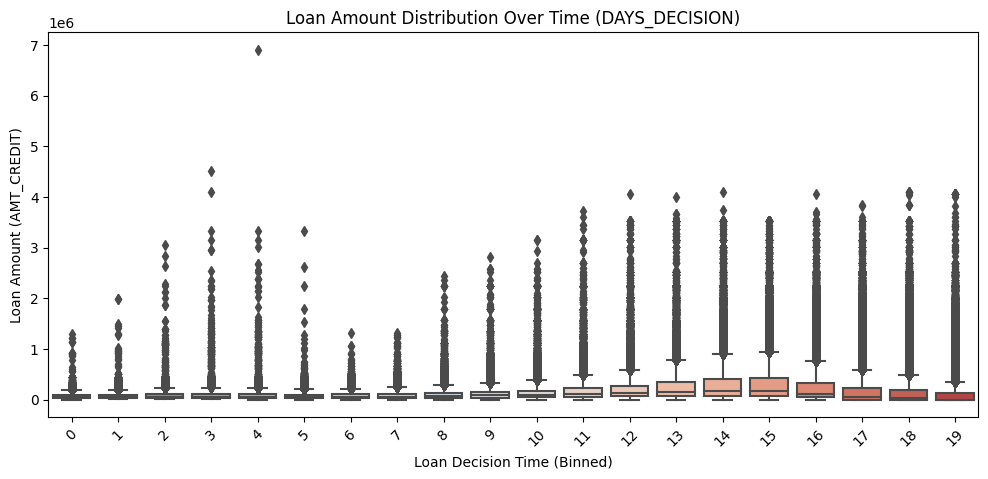

In [32]:
# Create a binned version of DAYS_DECISION for better visualization
df_previous_application["DAYS_DECISION_BIN"] = pd.cut(
    df_previous_application["DAYS_DECISION"], bins=20, labels=False
)

# Plot approval rate over time
plt.figure(figsize=(12, 5))
sns.boxplot(x="DAYS_DECISION_BIN", y="AMT_CREDIT", data=df_previous_application, palette="coolwarm")
plt.title("Loan Amount Distribution Over Time (DAYS_DECISION)")
plt.xlabel("Loan Decision Time (Binned)")
plt.ylabel("Loan Amount (AMT_CREDIT)")
plt.xticks(rotation=45)
plt.show()

### Key Takeaways:
- Loan amounts appear **relatively stable** over time, with no clear increasing or decreasing trend in `DAYS_DECISION`.  
- Some **high-value loans** are observed at various points in time, but they do not indicate a strong temporal pattern.  
- No significant trends, seasonality, or anomalies are detected, suggesting that loan amount decisions are not strongly time-dependent.  

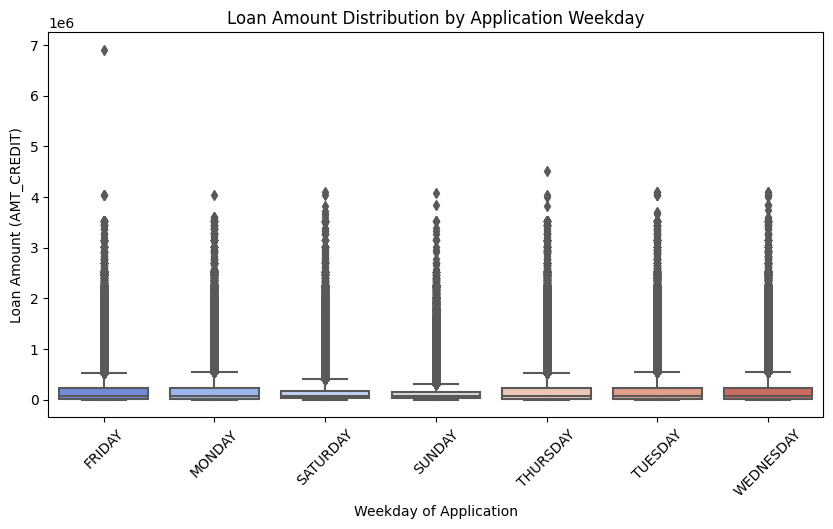

In [33]:
# Application weekday patterns
plt.figure(figsize=(10, 5))
sns.boxplot(x="WEEKDAY_APPR_PROCESS_START", y="AMT_CREDIT", data=df_previous_application, palette="coolwarm")
plt.title("Loan Amount Distribution by Application Weekday")
plt.xlabel("Weekday of Application")
plt.ylabel("Loan Amount (AMT_CREDIT)")
plt.xticks(rotation=45)
plt.show()

### Key Takeaways:
- Loan amounts **do not vary significantly** across different weekdays, suggesting that application day has little impact on loan size.  
- High-value loan applications are observed on all weekdays, with no noticeable spikes or dips on specific days.  
- There is no strong pattern indicating that certain days are more favorable for loan approvals or higher loan amounts.  

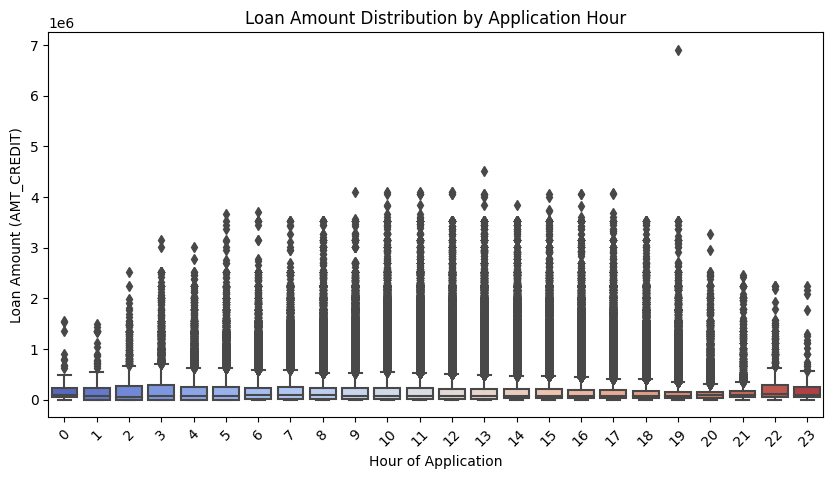

In [34]:
# Application hour patterns
plt.figure(figsize=(10, 5))
sns.boxplot(x="HOUR_APPR_PROCESS_START", y="AMT_CREDIT", data=df_previous_application, palette="coolwarm")
plt.title("Loan Amount Distribution by Application Hour")
plt.xlabel("Hour of Application")
plt.ylabel("Loan Amount (AMT_CREDIT)")
plt.xticks(rotation=45)
plt.show()

### Key Takeaways:
- Loan amounts remain **fairly stable across application hours**, with no strong peaks or dips.  
- A **slight increase in high-value loan applications** is observed between 8 AM and 6 PM, which may align with standard business hours.  
- No clear insights suggest that application hour significantly impacts loan amounts or approvals.  

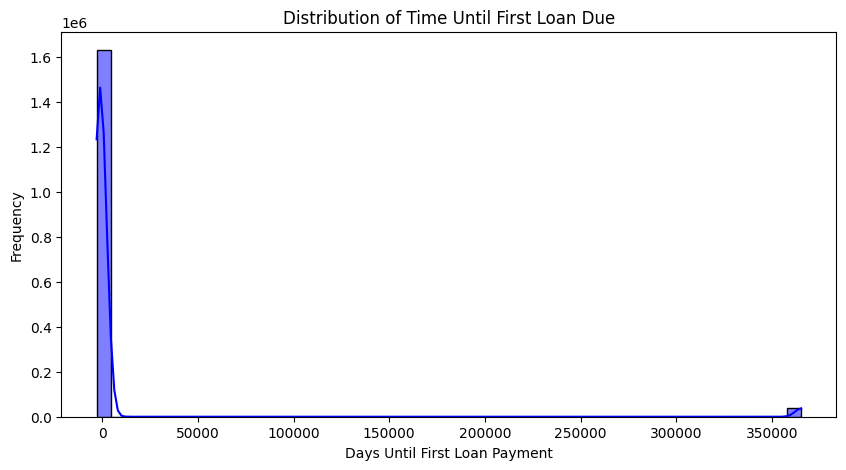

In [35]:
# Time until first loan payment
plt.figure(figsize=(10, 5))
sns.histplot(df_previous_application["DAYS_FIRST_DUE"], bins=50, kde=True, color="blue")
plt.title("Distribution of Time Until First Loan Due")
plt.xlabel("Days Until First Loan Payment")
plt.ylabel("Frequency")
plt.show()

### Key Takeaways:
- Most loans have a **short time until the first payment is due**, with a high concentration near zero days.  
- A **few extreme outliers** exist with unrealistically high values, possibly due to data entry errors or special loan conditions.  
- This distribution suggests that most loans require repayment quickly, which could impact default risk modeling.  

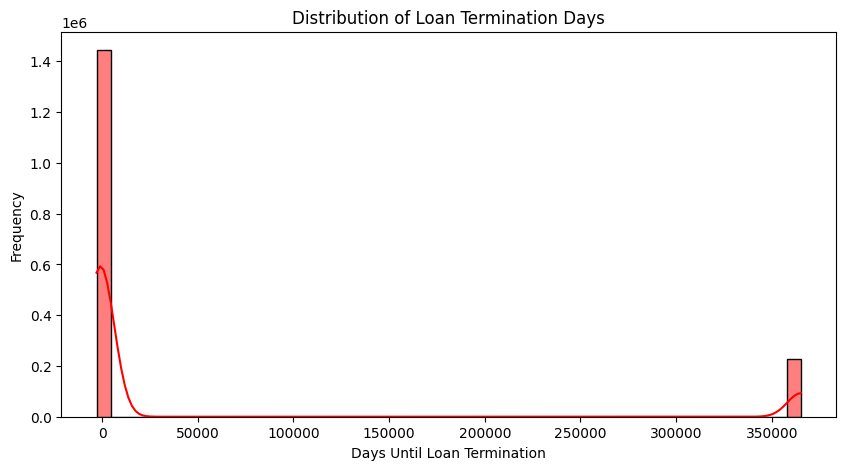

In [36]:
# Loan closure timing
plt.figure(figsize=(10, 5))
sns.histplot(df_previous_application["DAYS_TERMINATION"], bins=50, kde=True, color="red")
plt.title("Distribution of Loan Termination Days")
plt.xlabel("Days Until Loan Termination")
plt.ylabel("Frequency")
plt.show()

### Key Takeaways:
- Most loans are **terminated quickly**, with a high concentration near zero days, indicating short repayment periods.  
- A **small number of extreme outliers** exist with unrealistically high values, which could be due to data anomalies or specific long-term contracts.  
- This distribution is similar to `DAYS_FIRST_DUE`, reinforcing the trend that most loans in this dataset have a short lifecycle.  

### 4.8 Joint Plot Analysis
We use scatter plots with histograms to visualize relationships between numerical features.  
This helps identify patterns, correlations, and potential outliers.

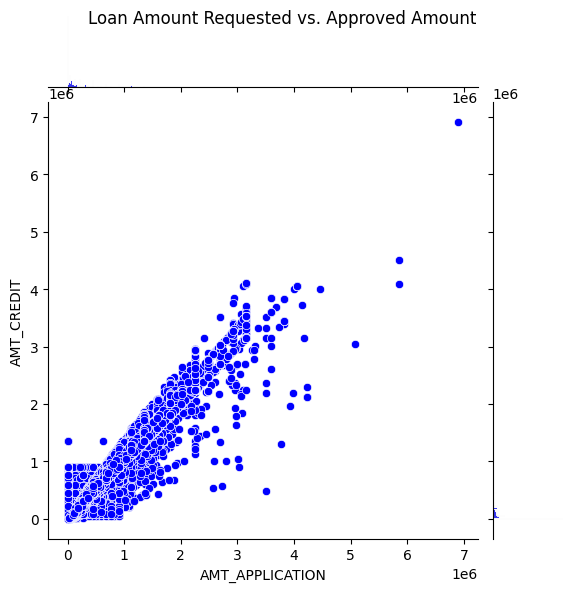

In [37]:
# Loan request vs. approved amount
sns.jointplot(x="AMT_APPLICATION", y="AMT_CREDIT", data=df_previous_application, kind="scatter", color="blue")
plt.suptitle("Loan Amount Requested vs. Approved Amount")
plt.show()

### Key Takeaways:
- **Strong positive correlation** between `AMT_APPLICATION` and `AMT_CREDIT`, indicating that higher requested loan amounts generally lead to higher approved amounts.  
- Some **instances where approved amounts are significantly lower than requested**, suggesting partial approvals or rejections.  
- A few **outliers with extreme values** may indicate data errors or special cases of very high loan requests.  

### 4.9 Additional EDA Visualisations

We plot histograms to visualize the distribution of key numerical features.  
This helps detect skewness, outliers, and possible data transformations.

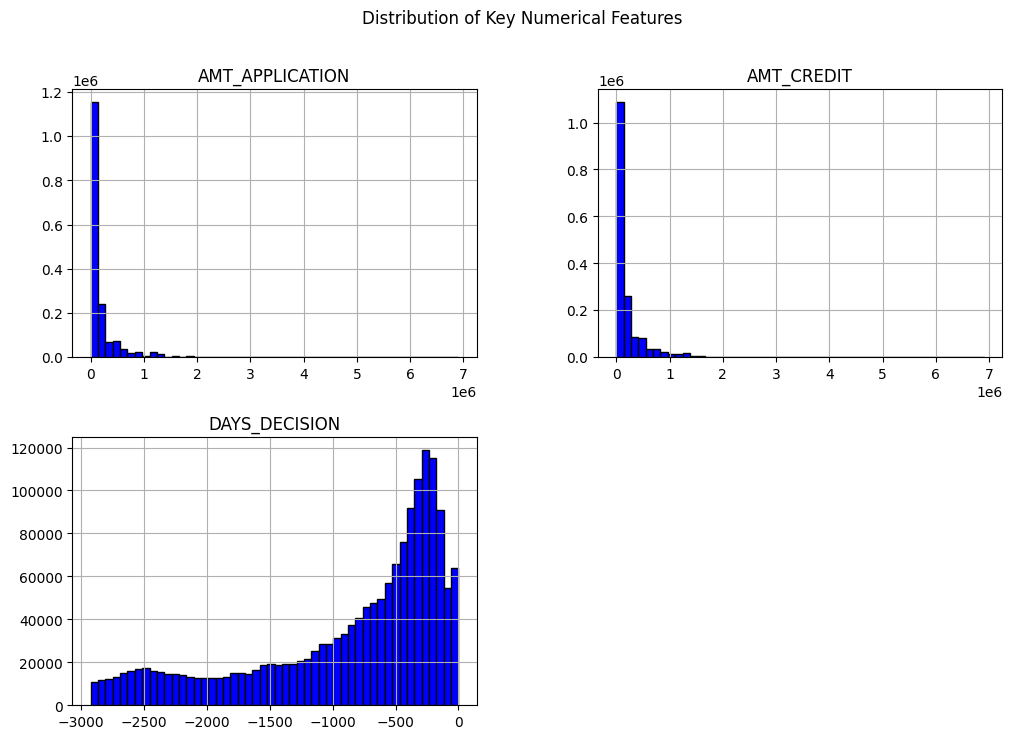

In [38]:
# Define numerical columns for histograms (after checking availability)
num_cols = ["AMT_APPLICATION", "AMT_CREDIT", "DAYS_DECISION"]

# Plot histograms
df_previous_application[num_cols].hist(figsize=(12, 8), bins=50, color='blue', edgecolor='black')
plt.suptitle("Distribution of Key Numerical Features")
plt.show()

### Key Takeaways:
- `AMT_APPLICATION` and `AMT_CREDIT` are **highly skewed**, with most loan amounts concentrated at lower values and a few extreme outliers.  
- `DAYS_DECISION` shows a **left-skewed distribution**, indicating that most loan applications occurred closer to the present, with fewer older applications.  
- The skewness in these features suggests that **log transformation** or **scaling techniques** may improve model performance depending on the chosen algorithm.  

We analyze the distribution of key categorical features using bar plots.  
This helps identify class imbalances, dominant categories, and rare values.

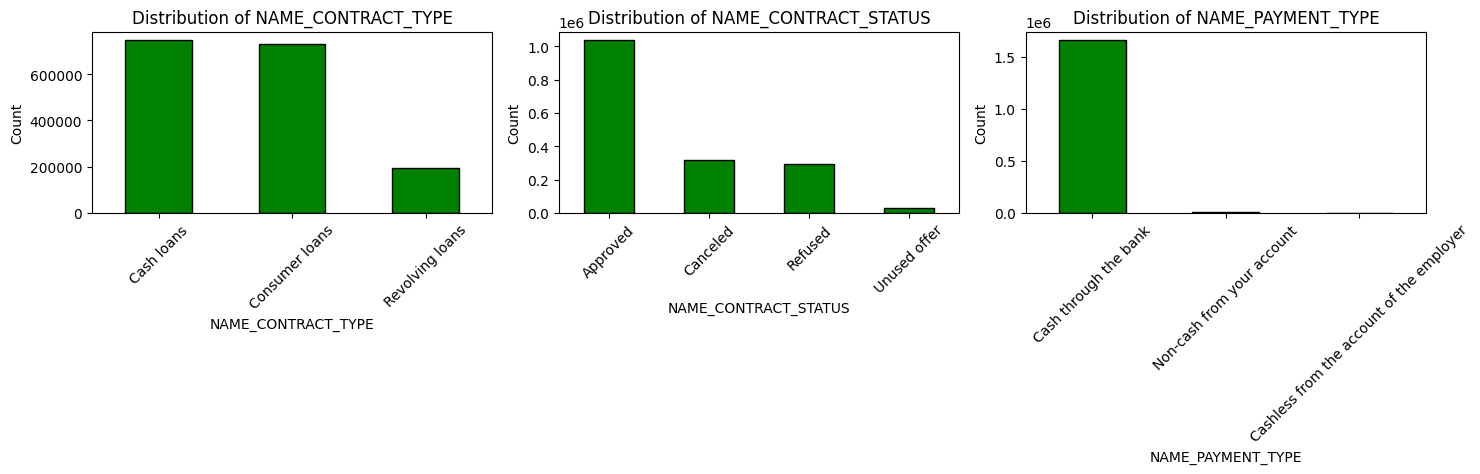

In [39]:
# Define categorical columns for bar plots
cat_cols = ["NAME_CONTRACT_TYPE", "NAME_CONTRACT_STATUS", "NAME_PAYMENT_TYPE"]

# Plot bar charts
fig, axes = plt.subplots(1, len(cat_cols), figsize=(15, 5))
for i, col in enumerate(cat_cols):
    df_previous_application[col].value_counts().plot(kind="bar", ax=axes[i], color="green", edgecolor="black")
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_ylabel("Count")
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

### Key Takeaways:
- **Cash loans and consumer loans** dominate the dataset, while revolving loans are significantly less common.  
- **Most applications are approved**, but a notable number are canceled or refused, indicating some level of risk assessment in lending.  
- **Cash through the bank** is the overwhelmingly dominant payment type, with alternative methods being rarely used.  

## 5. Feature Engineering (`previous_application.csv`)
We create new features to enhance predictive power by summarizing key attributes of the dataset.  
Feature engineering helps capture meaningful patterns that might improve model performance.

### 5.1 Credit Activity Features  
These features summarize past loan applications per client, capturing approval rates, loan types, and status counts.  
They help identify clients with frequent applications, high approval rates, or a history of refusals, which may impact credit risk.  

In [40]:
# Group by SK_ID_CURR and calculate loan counts
previous_application_credit_activity = df_previous_application.groupby("SK_ID_CURR").agg(
    previous_app_NUM_APPLICATIONS=("SK_ID_PREV", "count"),  # Total past applications per client
    previous_app_NUM_APPROVED_LOANS=("NAME_CONTRACT_STATUS", lambda x: (x == "Approved").sum()),  # Count approved loans
    previous_app_NUM_REFUSED_LOANS=("NAME_CONTRACT_STATUS", lambda x: (x == "Refused").sum()),  # Count refused loans
    previous_app_NUM_CANCELED_LOANS=("NAME_CONTRACT_STATUS", lambda x: (x == "Canceled").sum()),  # Count canceled loans
    previous_app_NUM_UNUSED_LOANS=("NAME_CONTRACT_STATUS", lambda x: (x == "Unused offer").sum()),  # Count unused offers
    previous_app_APPROVAL_RATE=("NAME_CONTRACT_STATUS", lambda x: (x == "Approved").sum() / len(x)),  # Approval ratio
    previous_app_NUM_REVOLVING_LOANS=("NAME_CONTRACT_TYPE", lambda x: (x == "Revolving loans").sum()),  # Count revolving loans
    previous_app_NUM_CASH_LOANS=("NAME_CONTRACT_TYPE", lambda x: (x == "Cash loans").sum()),  # Count cash loans
    previous_app_NUM_CONSUMER_LOANS=("NAME_CONTRACT_TYPE", lambda x: (x == "Consumer loans").sum()),  # Count consumer loans
    previous_app_NUM_REPEAT_LOANS=("NAME_CLIENT_TYPE", lambda x: (x == "Repeater").sum()),  # Clients with repeat loans
).reset_index()

# Preview the new features before merging
display(previous_application_credit_activity.head())

,SK_ID_CURR,previous_app_NUM_APPLICATIONS,previous_app_NUM_APPROVED_LOANS,previous_app_NUM_REFUSED_LOANS,previous_app_NUM_CANCELED_LOANS,previous_app_NUM_UNUSED_LOANS,previous_app_APPROVAL_RATE,previous_app_NUM_REVOLVING_LOANS,previous_app_NUM_CASH_LOANS,previous_app_NUM_CONSUMER_LOANS,previous_app_NUM_REPEAT_LOANS
0,100001,1,1,0,0,0,1.0,0,0,1,0
1,100002,1,1,0,0,0,1.0,0,0,1,0
2,100003,3,3,0,0,0,1.0,0,1,2,1
3,100004,1,1,0,0,0,1.0,0,0,1,0
4,100005,2,1,0,1,0,0.5,0,1,1,1


### 5.2 Loan Amount Features  
These features summarize loan amounts per client, capturing total, average, minimum, and maximum requested and approved amounts.  
They also compute approval ratios and application-to-credit ratios, which can highlight clients who frequently request higher loans than they receive.  
Handling missing values and avoiding division errors ensures robust feature computation.  

In [41]:
# Group by SK_ID_CURR and calculate loan amount statistics
previous_application_loan_amounts = df_previous_application.groupby("SK_ID_CURR").agg(
    previous_app_TOTAL_APPLICATION_AMOUNT=("AMT_APPLICATION", "sum"),  # Total loan amount requested
    previous_app_TOTAL_APPROVED_AMOUNT=("AMT_CREDIT", "sum"),  # Total approved loan amount
    previous_app_AVG_APPLICATION_AMOUNT=("AMT_APPLICATION", "mean"),  # Average loan amount requested
    previous_app_AVG_APPROVED_AMOUNT=("AMT_CREDIT", "mean"),  # Average approved loan amount
    previous_app_MAX_APPLICATION_AMOUNT=("AMT_APPLICATION", "max"),  # Max requested amount
    previous_app_MAX_APPROVED_AMOUNT=("AMT_CREDIT", "max"),  # Max approved amount
    previous_app_MIN_APPLICATION_AMOUNT=("AMT_APPLICATION", "min"),  # Min requested amount
    previous_app_MIN_APPROVED_AMOUNT=("AMT_CREDIT", "min"),  # Min approved amount
    previous_app_STD_APPLICATION_AMOUNT=("AMT_APPLICATION", "std"),  # Standard deviation of requested amounts
    previous_app_STD_APPROVED_AMOUNT=("AMT_CREDIT", "std"),  # Standard deviation of approved amounts
    previous_app_TOTAL_PAYMENT_AMOUNT=("CNT_PAYMENT", lambda x: x.fillna(0).sum()),  # Total number of payments
).reset_index()

# Compute Approval Ratio and Application-to-Credit Ratio (Avoid division by zero)
previous_application_loan_amounts["previous_app_APPROVAL_AMOUNT_RATIO"] = (
    previous_application_loan_amounts["previous_app_TOTAL_APPROVED_AMOUNT"] / 
    previous_application_loan_amounts["previous_app_TOTAL_APPLICATION_AMOUNT"]
)

previous_application_loan_amounts["previous_app_APPLICATION_TO_CREDIT_RATIO"] = (
    previous_application_loan_amounts["previous_app_TOTAL_APPLICATION_AMOUNT"] / 
    previous_application_loan_amounts["previous_app_TOTAL_APPROVED_AMOUNT"]
)

# Handle division by zero
previous_application_loan_amounts["previous_app_APPROVAL_AMOUNT_RATIO"] = (
    previous_application_loan_amounts["previous_app_APPROVAL_AMOUNT_RATIO"]
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0)
)

previous_application_loan_amounts["previous_app_APPLICATION_TO_CREDIT_RATIO"] = (
    previous_application_loan_amounts["previous_app_APPLICATION_TO_CREDIT_RATIO"]
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0)
)

# Preview the new features before merging
display(previous_application_loan_amounts.head())

,SK_ID_CURR,previous_app_TOTAL_APPLICATION_AMOUNT,previous_app_TOTAL_APPROVED_AMOUNT,previous_app_AVG_APPLICATION_AMOUNT,previous_app_AVG_APPROVED_AMOUNT,previous_app_MAX_APPLICATION_AMOUNT,previous_app_MAX_APPROVED_AMOUNT,previous_app_MIN_APPLICATION_AMOUNT,previous_app_MIN_APPROVED_AMOUNT,previous_app_STD_APPLICATION_AMOUNT,previous_app_STD_APPROVED_AMOUNT,previous_app_TOTAL_PAYMENT_AMOUNT,previous_app_APPROVAL_AMOUNT_RATIO,previous_app_APPLICATION_TO_CREDIT_RATIO
0,100001,24835.5,23787.0,24835.50,23787.00,24835.5,23787.0,24835.5,23787.0,NaN,NaN,8.0,0.957782,1.044079
1,100002,179055.0,179055.0,179055.00,179055.00,179055.0,179055.0,179055.0,179055.0,NaN,NaN,24.0,1.000000,1.000000
2,100003,1306309.5,1452573.0,435436.50,484191.00,900000.0,1035882.0,68809.5,68053.5,424161.620549,497949.861808,30.0,1.111967,0.899307
3,100004,24282.0,20106.0,24282.00,20106.00,24282.0,20106.0,24282.0,20106.0,NaN,NaN,4.0,0.828021,1.207699
4,100005,44617.5,40153.5,22308.75,20076.75,44617.5,40153.5,0.0,0.0,31549.336810,28392.812138,24.0,0.899950,1.111173


### 5.3 Time-Based Features  
These features capture loan timing details, such as the average time since past applications, loan duration, and time to first payment.  
By converting days into years, they provide a clearer picture of loan history and repayment schedules.  

In [42]:
# Group by SK_ID_CURR and calculate time-related statistics
previous_application_time_features = df_previous_application.groupby("SK_ID_CURR").agg(
    previous_app_AVG_TIME_SINCE_APPLICATION=("DAYS_DECISION", lambda x: abs(x.mean()) / 365),  # Average time since past applications in years
    previous_app_MAX_TIME_SINCE_APPLICATION=("DAYS_DECISION", lambda x: abs(x.min()) / 365),  # Max time since a past application (oldest loan)
    previous_app_TIME_SINCE_LAST_APPLICATION=("DAYS_DECISION", lambda x: abs(x.max()) / 365),  # Time since most recent application
    previous_app_AVG_LOAN_DURATION=("DAYS_TERMINATION", lambda x: abs(x.mean()) / 365),  # Average loan duration in years
    previous_app_MAX_LOAN_DURATION=("DAYS_TERMINATION", lambda x: abs(x.max()) / 365),  # Maximum loan duration
    previous_app_AVG_TIME_TO_FIRST_PAYMENT=("DAYS_FIRST_DUE", lambda x: abs(x.mean()) / 365),  # Mean time to first payment
    previous_app_AVG_TIME_REMAINING=("DAYS_LAST_DUE", lambda x: abs(x.mean()) / 365)  # Average remaining repayment duration
).reset_index()

# Preview the new features before merging
display(previous_application_time_features.head())

,SK_ID_CURR,previous_app_AVG_TIME_SINCE_APPLICATION,previous_app_MAX_TIME_SINCE_APPLICATION,previous_app_TIME_SINCE_LAST_APPLICATION,previous_app_AVG_LOAN_DURATION,previous_app_MAX_LOAN_DURATION,previous_app_AVG_TIME_TO_FIRST_PAYMENT,previous_app_AVG_TIME_REMAINING
0,100001,4.767123,4.767123,4.767123,4.416438,4.416438,4.682192,4.435616
1,100002,1.660274,1.660274,1.660274,0.046575,0.046575,1.547945,0.068493
2,100003,3.575342,6.413699,2.043836,2.869406,1.443836,3.491324,2.888584
3,100004,2.232877,2.232877,2.232877,1.956164,1.956164,2.147945,1.983562
4,100005,1.468493,2.073973,0.863014,1.313699,1.260274,2.105479,1.373973


### 5.4 Credit Overdue Features  
These features track overdue applications, including the number of late first payments and overdue loan amounts.  
They also calculate the proportion of overdue applications per client, helping to assess repayment behavior.  

In [43]:
# Group by SK_ID_CURR and calculate overdue-related statistics
previous_application_credit_overdue = df_previous_application.groupby("SK_ID_CURR").agg(
    previous_app_NUM_OVERDUE_APPLICATIONS=("DAYS_FIRST_DUE", lambda x: (x < 0).sum()),  # Count applications with overdue first payments
    previous_app_TOTAL_OVERDUE_AMOUNT=("DAYS_LAST_DUE", lambda x: (x < 0).sum()),  # Count applications that ended in overdue
    previous_app_PROPORTION_OVERDUE_APPLICATIONS=("DAYS_LAST_DUE", lambda x: (x < 0).mean())  # Proportion of overdue applications
).reset_index()

# Preview the new features before merging
display(previous_application_credit_overdue.head())

,SK_ID_CURR,previous_app_NUM_OVERDUE_APPLICATIONS,previous_app_TOTAL_OVERDUE_AMOUNT,previous_app_PROPORTION_OVERDUE_APPLICATIONS
0,100001,1,1,1.0
1,100002,1,1,1.0
2,100003,3,3,1.0
3,100004,1,1,1.0
4,100005,2,2,1.0


### 5.5 Categorical Features Aggregation  
These features summarize key categorical attributes per client, such as approval percentage and most common contract type.  
They also track the most frequent loan purpose and whether the client has any past refusals, which may indicate credit risk.  

In [44]:
# Group by SK_ID_CURR and aggregate categorical features
previous_application_categorical_features = df_previous_application.groupby("SK_ID_CURR").agg(
    previous_app_PERCENT_APPROVED=("NAME_CONTRACT_STATUS", lambda x: (x == "Approved").sum() / len(x)),  # Percentage of approved applications
    previous_app_MOST_COMMON_CONTRACT_TYPE=("NAME_CONTRACT_TYPE", lambda x: x.mode()[0] if not x.mode().empty else "Unknown"),  # Most common contract type
    previous_app_MOST_COMMON_LOAN_PURPOSE=("NAME_CASH_LOAN_PURPOSE", lambda x: x.mode()[0] if not x.mode().empty else "Unknown"),  # Most common loan purpose
    previous_app_HAS_REFUSALS=("NAME_CONTRACT_STATUS", lambda x: 1 if (x == "Refused").any() else 0)  # Binary flag for past refusals
).reset_index()

# Preview the new features before merging
display(previous_application_categorical_features.head())

,SK_ID_CURR,previous_app_PERCENT_APPROVED,previous_app_MOST_COMMON_CONTRACT_TYPE,previous_app_MOST_COMMON_LOAN_PURPOSE,previous_app_HAS_REFUSALS
0,100001,1.0,Consumer loans,XAP,0
1,100002,1.0,Consumer loans,XAP,0
2,100003,1.0,Consumer loans,XAP,0
3,100004,1.0,Consumer loans,XAP,0
4,100005,0.5,Cash loans,XAP,0


## 6. Aggregation (`previous_application.csv`)
We aggregate numerical and categorical features at the client level to summarize loan-related patterns. This reduces dataset size while retaining essential information.

### 6.1 Aggregate All Numeric and Categorical Columns
- Numerical features are aggregated using mean, sum, max, and min to capture overall trends.
- Categorical features are aggregated using the most frequent category per client.

This step ensures that client-level insights are preserved for modeling while reducing redundancy.

In [45]:
# Aggregate df_previous_application before merging
print("\nAggregating df_previous_application by SK_ID_CURR...")

# Exclude SK_ID_PREV (loan-level unique identifier)
agg_numeric_columns = df_previous_application.select_dtypes(include=['number']).drop(columns=['SK_ID_PREV'], errors='ignore')

# Aggregate numerical features (without std for cleaner results)
agg_funcs = ['mean', 'sum', 'max', 'min']
agg_numeric = agg_numeric_columns.groupby('SK_ID_CURR').agg(agg_funcs)

# Rename columns to avoid multi-index issue
agg_numeric.columns = ['previous_app_agg_' + '_'.join(col) for col in agg_numeric.columns]
agg_numeric.reset_index(inplace=True)

# Optimize categorical feature aggregation
agg_categorical_columns = df_previous_application.select_dtypes(include=['object', 'category']).drop(columns=['SK_ID_PREV'], errors='ignore')

if not agg_categorical_columns.empty:
    # Instead of mode(), use value_counts().idxmax() for speed
    agg_categorical_columns = df_previous_application[['SK_ID_CURR']].join(agg_categorical_columns)
    
    agg_categorical = agg_categorical_columns.groupby('SK_ID_CURR').agg(lambda x: x.value_counts().idxmax() if not x.empty else "Unknown")
    agg_categorical.columns = ['previous_app_agg_' + col + '_most_frequent' for col in agg_categorical.columns]
    agg_categorical.reset_index(inplace=True)

    # Merge aggregated numerical and categorical features
    df_previous_application_aggregated = agg_numeric.merge(agg_categorical, on="SK_ID_CURR", how="left")
else:
    df_previous_application_aggregated = agg_numeric

# Check new shape
print(f"✅ Aggregation complete. New df_previous_application_aggregated shape: {df_previous_application_aggregated.shape}")

# Preview the aggregated dataframe
display(df_previous_application_aggregated.head())


Aggregating df_previous_application by SK_ID_CURR...
✅ Aggregation complete. New df_previous_application_aggregated shape: (338857, 72)


,SK_ID_CURR,previous_app_agg_AMT_ANNUITY_mean,previous_app_agg_AMT_ANNUITY_sum,previous_app_agg_AMT_ANNUITY_max,previous_app_agg_AMT_ANNUITY_min,previous_app_agg_AMT_APPLICATION_mean,previous_app_agg_AMT_APPLICATION_sum,previous_app_agg_AMT_APPLICATION_max,previous_app_agg_AMT_APPLICATION_min,previous_app_agg_AMT_CREDIT_mean,...,previous_app_agg_NAME_CONTRACT_STATUS_most_frequent,previous_app_agg_NAME_PAYMENT_TYPE_most_frequent,previous_app_agg_CODE_REJECT_REASON_most_frequent,previous_app_agg_NAME_TYPE_SUITE_most_frequent,previous_app_agg_NAME_CLIENT_TYPE_most_frequent,previous_app_agg_NAME_PORTFOLIO_most_frequent,previous_app_agg_CHANNEL_TYPE_most_frequent,previous_app_agg_NAME_YIELD_GROUP_most_frequent,previous_app_agg_PRODUCT_COMBINATION_most_frequent,previous_app_agg_NFLAG_INSURED_ON_APPROVAL_most_frequent
0,100001,3951.000,3951.000,3951.000,3951.000,24835.50,24835.5,24835.5,24835.5,23787.00,...,Approved,Cash through the bank,XAP,Family,Refreshed,POS,Country-wide,high,POS mobile with interest,0.0
1,100002,9251.775,9251.775,9251.775,9251.775,179055.00,179055.0,179055.0,179055.0,179055.00,...,Approved,Cash through the bank,XAP,Unaccompanied,New,POS,Stone,low_normal,POS other with interest,0.0
2,100003,56553.990,169661.970,98356.995,6737.310,435436.50,1306309.5,900000.0,68809.5,484191.00,...,Approved,Cash through the bank,XAP,Family,Refreshed,POS,Country-wide,middle,POS household with interest,1.0
3,100004,5357.250,5357.250,5357.250,5357.250,24282.00,24282.0,24282.0,24282.0,20106.00,...,Approved,Cash through the bank,XAP,Unaccompanied,New,POS,Regional / Local,middle,POS mobile without interest,0.0
4,100005,8031.600,16063.200,11250.000,4813.200,22308.75,44617.5,44617.5,0.0,20076.75,...,Approved,Cash through the bank,XAP,Unaccompanied,New,POS,Country-wide,high,Cash,0.0


## 7. Merging (`previous_application.csv`)
We merge all newly created feature tables into a single dataset using a **left join on SK_ID_CURR**.  
This ensures that no client records are lost while incorporating the engineered features.

In [46]:
# Function to safely merge dataframes and print debugging info
def safe_merge(df_main, df_new, merge_on="SK_ID_CURR", name=""):
    """ Merges two dataframes and prints sanity checks """
    prev_shape = df_main.shape
    df_main = df_main.merge(df_new, on=merge_on, how="left")

    print(f"✅ Merged {name}: {prev_shape} -> {df_main.shape}")
    missing_values = df_main.isnull().sum()[df_main.isnull().sum() > 0]
    
    if not missing_values.empty:
        print(f"⚠️ Missing Values in {name} After Merge:\n{missing_values}")
    
    print("-" * 50)
    return df_main

# Apply Safe Merges at the End
df_previous_application_aggregated = safe_merge(df_previous_application_aggregated, previous_application_credit_activity, name="previous_application_credit_activity")
df_previous_application_aggregated = safe_merge(df_previous_application_aggregated, previous_application_loan_amounts, name="previous_application_loan_amounts")
df_previous_application_aggregated = safe_merge(df_previous_application_aggregated, previous_application_time_features, name="previous_application_time_features")
df_previous_application_aggregated = safe_merge(df_previous_application_aggregated, previous_application_credit_overdue, name="previous_application_credit_overdue")
df_previous_application_aggregated = safe_merge(df_previous_application_aggregated, previous_application_categorical_features, name="previous_application_categorical_features")

print("✅ All feature tables merged successfully!")

✅ Merged previous_application_credit_activity: (338857, 72) -> (338857, 82)
--------------------------------------------------
✅ Merged previous_application_loan_amounts: (338857, 82) -> (338857, 95)
⚠️ Missing Values in previous_application_loan_amounts After Merge:
previous_app_STD_APPLICATION_AMOUNT    60458
previous_app_STD_APPROVED_AMOUNT       60458
dtype: int64
--------------------------------------------------
✅ Merged previous_application_time_features: (338857, 95) -> (338857, 102)
⚠️ Missing Values in previous_application_time_features After Merge:
previous_app_STD_APPLICATION_AMOUNT    60458
previous_app_STD_APPROVED_AMOUNT       60458
dtype: int64
--------------------------------------------------
✅ Merged previous_application_credit_overdue: (338857, 102) -> (338857, 105)
⚠️ Missing Values in previous_application_credit_overdue After Merge:
previous_app_STD_APPLICATION_AMOUNT    60458
previous_app_STD_APPROVED_AMOUNT       60458
dtype: int64
------------------------------

In [47]:
# Handle NaNs in standard deviation columns
df_previous_application_aggregated["previous_app_STD_APPLICATION_AMOUNT"] = df_previous_application_aggregated["previous_app_STD_APPLICATION_AMOUNT"].fillna(0)
df_previous_application_aggregated["previous_app_STD_APPROVED_AMOUNT"] = df_previous_application_aggregated["previous_app_STD_APPROVED_AMOUNT"].fillna(0)

### 7.1 Feature Validation
Before saving, we validate the dataset by checking for:  
- **Missing values** (standard NaNs and hidden NaNs stored as text)  
- **Infinite values** (Inf or -Inf, which can cause issues in modeling)  

Once verified, the aggregated dataset is saved.

In [48]:
# Step 1: Check for standard NaN values
missing_values_previous_application_aggregated = df_previous_application_aggregated.isna().sum()
missing_values_previous_application_aggregated = missing_values_previous_application_aggregated[missing_values_previous_application_aggregated > 0]
print("\nStandard Missing Values in Aggregated Previous Application Features After Merging:")
print(missing_values_previous_application_aggregated if not missing_values_previous_application_aggregated.empty else "✅ No standard NaN values detected.")

# Step 2: Check for hidden NaNs (empty strings or "nan" stored as a string)
hidden_nans_previous_application_aggregated = (df_previous_application_aggregated == "").sum() + (df_previous_application_aggregated == "nan").sum()
hidden_nans_previous_application_aggregated = hidden_nans_previous_application_aggregated[hidden_nans_previous_application_aggregated > 0]
print("\nHidden NaNs (Empty Strings or 'nan' as Text) in Aggregated Previous Application Features After Merging:")
print(hidden_nans_previous_application_aggregated if not hidden_nans_previous_application_aggregated.empty else "✅ No hidden NaNs detected.")


Standard Missing Values in Aggregated Previous Application Features After Merging:
✅ No standard NaN values detected.

Hidden NaNs (Empty Strings or 'nan' as Text) in Aggregated Previous Application Features After Merging:
✅ No hidden NaNs detected.


In [49]:
# Step 3: Check for Inf values
inf_values_previous_application_aggregated = df_previous_application_aggregated.replace([np.inf, -np.inf], np.nan).isna().sum()
inf_values_previous_application_aggregated = inf_values_previous_application_aggregated[inf_values_previous_application_aggregated > 0]

print("\nInfinite Values in Aggregated Previous Application Features Before Merging:")
if inf_values_previous_application_aggregated.empty:
    print("✅ No Inf values detected.")
else:
    print(inf_values_previous_application_aggregated)


Infinite Values in Aggregated Previous Application Features Before Merging:
✅ No Inf values detected.


In [50]:
df_previous_application_aggregated.to_csv("previous_application_aggregated.csv", index=False)
df_previous_application_aggregated.to_pickle("previous_application_aggregated.pkl")
print("✅ Previous Application aggregated dataset saved successfully!")

✅ Previous Application aggregated dataset saved successfully!
